# Perform a simulation with a semi-empirical rudder model (ModularSimulator)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/08/23 08:37:55] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=578123;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=261266;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/08/23 08:38:02] INFO     Kedro project phd                                                      ]8;id=372716;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=773307;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=376509;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=790211;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=976381;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=588427;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=67929;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487920;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=845498;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=247699;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=289529;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=121266;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=248417;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=510555;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=528818;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=198211;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=537479;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=830311;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_old= model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

In [5]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [6]:
result_old = model_old.simulate(data)

## Simulation with the semi-empirical rudder model

In [7]:
rudder_particulars = {
'x_R'   : ship_data['x_r'],
'y_R'   : 0,
'z_R'   : 0,
'A_R'   : 70/(ship_data['scale_factor']**2),
'b_R'   : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
'w_f'   :ship_data['w_p0'],
}

prop_data = {
'r_0': ship_data['D']/2,
'x': 0.10,  # Guessing...
}

rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(40),
"kappa": 0.5, # (Small value means much flow straightening)
"nu":1.18849E-06,
}
parameters = dict(model_old.parameters)
parameters.update(rudder_parameters)

In [8]:
ship_parameters = model_old.ship_parameters.copy()
ship_parameters.update(rudder_particulars)
ship_parameters.update(prop_data)

In [9]:
fx_eq = fx_eq.subs(X_D,X_D_)
fy_eq = fy_eq.subs(Y_D,Y_D_)
mz_eq = mz_eq.subs(N_D,N_D_)

eq_X_force = fx_eq.subs(X_D_, X_H + X_R)
eq_Y_force = fy_eq.subs(Y_D_, Y_H + Y_R)
eq_N_force = mz_eq.subs(N_D_, N_H + N_R)

X_eq = X_eom.subs(X_force,eq_X_force.rhs)
Y_eq = Y_eom.subs(Y_force,eq_Y_force.rhs)
N_eq = N_eom.subs(N_force,eq_N_force.rhs)
subs = [
    (p.Xvdot, 0),
    (p.Xrdot, 0),
    (p.Yudot, 0),
    # (p.Yrdot,0),  # this is probably not true
    (p.Nudot, 0),
    # (p.Nvdot,0),# this is probably not true
]
X_eq=X_eq.subs(subs)
Y_eq=Y_eq.subs(subs)
N_eq=N_eq.subs(subs)

display(X_eq)
display(Y_eq)
display(N_eq)

Eq(m*(\dot{u} - r**2*x_G - r*v), X_H + X_R + X_{\dot{u}}*\dot{u})

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_H + Y_R + Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v})

Eq(I_z*\dot{r} + m*x_G*(\dot{v} + r*u), N_H + N_R + N_{\dot{r}}*\dot{r} + N_{\dot{v}}*\dot{v})

In [10]:
model = ModularVesselSimulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, ship_parameters=ship_parameters, parameters=parameters, control_keys=model_old.control_keys)

## Add subsystems

In [11]:
eq_X_old = sp.Eq(X_H,model_old.X_qs_eq.rhs)
eq_Y_old = sp.Eq(Y_H,model_old.Y_qs_eq.rhs)
eq_N_old = sp.Eq(N_H,model_old.N_qs_eq.rhs)

In [12]:
expressions = [part for part in eq_X_old.rhs.args if delta in part.free_symbols]
eq_X_R = sp.Eq(X_R,reduce(add,expressions))

expressions = [part for part in eq_Y_old.rhs.args if delta in part.free_symbols]
eq_Y_R = sp.Eq(Y_R,reduce(add,expressions))

expressions = [part for part in eq_N_old.rhs.args if delta in part.free_symbols]
eq_N_R = sp.Eq(N_R,reduce(add,expressions))

display(eq_X_R)
display(eq_Y_R)
display(eq_N_R)

Eq(X_R, X_{deltadelta}*delta**2)

Eq(Y_R, Y_{delta}*delta + Y_{thrustdelta}*delta*thrust + Y_{vvdelta}*delta*v**2)

Eq(N_R, N_{delta}*delta + N_{thrustdelta}*delta*thrust + N_{vvdelta}*delta*v**2)

In [13]:
eq_X_H = sp.Eq(X_H,eq_X_old.rhs.subs(eq_X_R.rhs,0))
eq_Y_H = sp.Eq(Y_H,eq_Y_old.rhs.subs(eq_Y_R.rhs,0))
eq_N_H = sp.Eq(N_H,eq_N_old.rhs.subs(eq_N_R.rhs,0))
display(eq_X_H)
display(eq_Y_H)
display(eq_N_H)

Eq(X_H, X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

Eq(Y_H, Y_{r}*r + Y_{thrust}*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_H, N_{r}*r + N_{thrust}*thrust + N_{ur}*r*u + N_{u}*u + N_{v}*v)

### Hull

In [14]:
equations_hull = [eq_X_H, eq_Y_H, eq_N_H]
hull = PrimeEquationSubSystem(ship=model, equations=equations_hull)
model.subsystems['hull'] = hull

### Semi-empirical rudder

In [15]:
rudders = SemiempiricalRudderSystem(ship=model)
model.subsystems['rudders'] = rudders

### Save

In [16]:
model_loader["semiempirical_rudder"] = model
catalog.save(f"{ship}.models", model_loader)

[06/08/23 08:38:46] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=825335;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=724064;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

## Simulate

In [17]:
result = model.simulate(data)

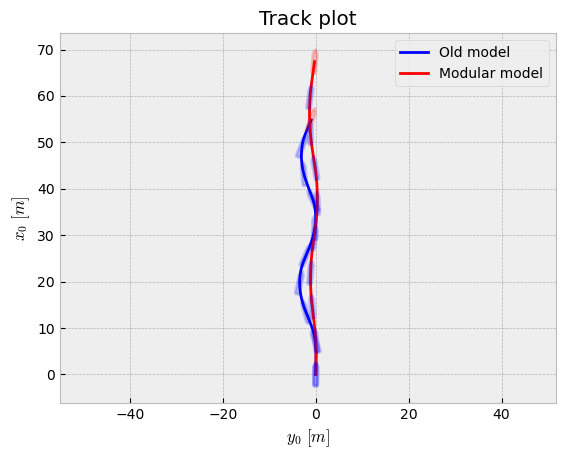

In [18]:
dataframes = {
              'Old model':result_old.result,
              'Modular model':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
ax.get_figure().savefig("summaries/simulation_semiempirical.png")

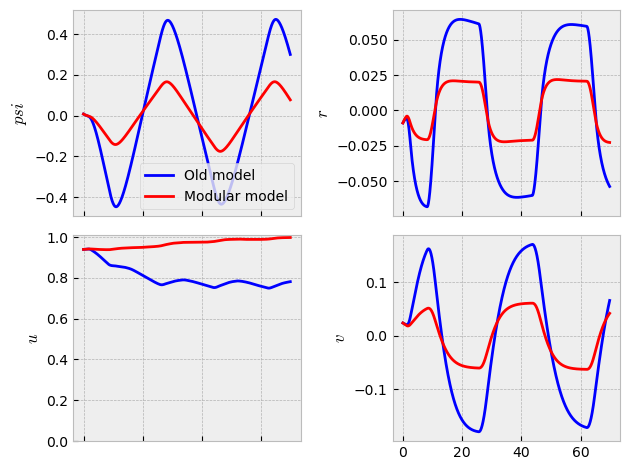

In [19]:
plot(dataframes, keys=['u','v','r','psi']);


In [20]:
result.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,X_H,Y_H,N_H,V_x,C_L,X_R,Y_R,N_R,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.001429,-0.003324,0.005345,0.736567,-5.270261,4.546532,0.723937,-0.059167,-0.029864,-0.641870,1.554738,0.706704,-5.912131,6.101270,-0.025223,0.939521
0.01,0.939237,0.023662,-0.008826,0.006527,-0.036697,0.007784,0.001499,-0.003340,0.005317,0.766245,-5.266639,4.517713,0.723948,-0.058967,-0.029803,-0.639701,1.549483,0.736442,-5.906340,6.067196,-0.025187,0.939535
0.02,0.939255,0.023628,-0.008773,0.015918,-0.036388,0.007696,0.001514,-0.003356,0.005288,0.772023,-5.262972,4.489062,0.723961,-0.058755,-0.029739,-0.637403,1.543916,0.742284,-5.900374,6.032978,-0.025151,0.939552
0.03,0.939270,0.023595,-0.008721,0.025308,-0.036080,0.007609,0.001443,-0.003372,0.005259,0.740693,-5.259225,4.460553,0.723972,-0.058543,-0.029675,-0.635110,1.538363,0.711018,-5.894335,5.998916,-0.025115,0.939566
0.04,0.939282,0.023561,-0.008668,0.034699,-0.035773,0.007522,0.001281,-0.003387,0.005231,0.670253,-5.255403,4.432190,0.723981,-0.058333,-0.029611,-0.632824,1.532825,0.640642,-5.888226,5.965015,-0.025079,0.939577


<Axes: >

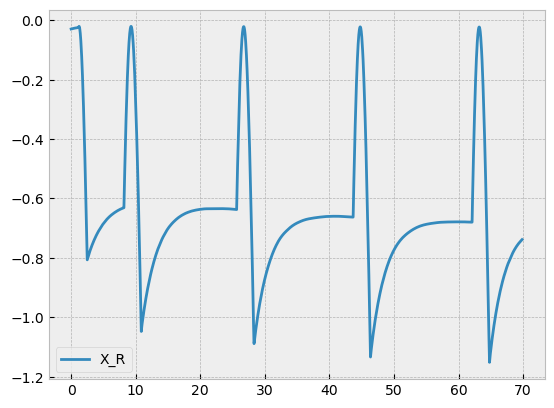

In [21]:
result.plot(y='X_R')

<Axes: >

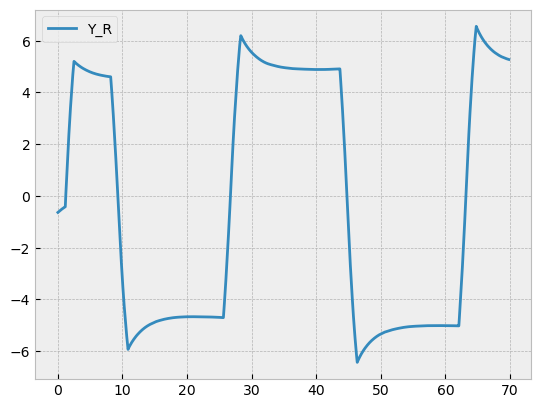

In [22]:
result.plot(y='Y_R')